In [1]:
import pandas as pd
from tabulate import tabulate
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates4
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter


In [2]:
xl = pd.ExcelFile('Data/Transactions.xlsx');

In [3]:
df = xl.parse('Credit-Card-Transactions')

In [4]:
df[['City','Country']]=df.City.str.split(',',expand=True)

In [5]:
df.rename(columns={'Exp Type':'Exp_Type'}, inplace=True)
df.rename(columns={'Card Type':'Card_Type'}, inplace=True)

# REPORT - Potential transaction frauds


#### The purpose of this report is to find possible transactional fraud through data analysis.
We have assumed that transactions greater than 95% of others and transactions performed more than three times with the same Day, City, Card Type, and Gender are possible fraudulent transactions.

We calculate the 95th percentile by Expense Type, to find the number where 95% of all other numbers are less than it.

In [6]:
quatile_95 = df.groupby('Exp_Type')['Amount'].quantile(0.95).reset_index()
quatile_95.rename(columns={'Amount':'Quartile_95'}, inplace=True)
quatile_95

,Exp_Type,Quartile_95
0,Bills,401493.35
1,Entertainment,285028.80
2,Food,285255.40
3,Fuel,284327.60
4,Grocery,284572.25
5,Travel,281222.25


We get the following list of potential fraudulent transactions when we apply our rule:

In [7]:
df_fraud = df.merge(quatile_95, left_on='Exp_Type', right_on='Exp_Type')
df1 = df_fraud[(df_fraud.Amount > df_fraud.Quartile_95)]
df1 = df1[['City','Date','Card_Type','Exp_Type','Gender','Amount']].sort_values(by=[ 'Amount', 'Date', 'City', 'Exp_Type'], ascending=False)

In [8]:
df1

,City,Date,Card_Type,Exp_Type,Gender,Amount
80,Greater Mumbai,2014-10-14,Platinum,Bills,F,998077
134,Delhi,2013-10-27,Gold,Bills,F,996754
254,Ahmedabad,2015-04-17,Gold,Bills,F,996291
183,Ahmedabad,2014-08-27,Platinum,Bills,F,995634
330,Delhi,2014-06-07,Signature,Bills,F,994537
...,...,...,...,...,...,...
23816,Ballari,2014-10-15,Platinum,Fuel,F,284354
25567,Jaipur,2014-12-24,Gold,Travel,M,282876
25860,Jaipur,2015-05-09,Silver,Travel,F,282385
25562,Lucknow,2015-03-26,Silver,Travel,F,281922


Through the graph we can see in what kind of expenses these transactions were made.

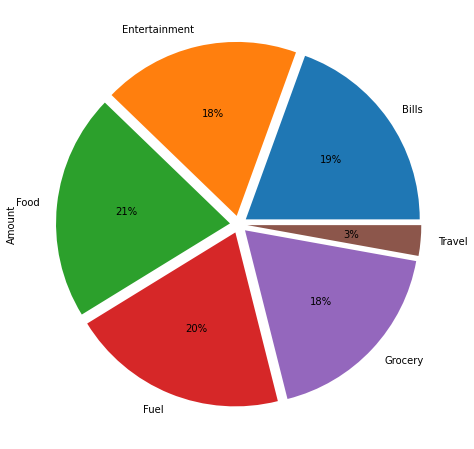

In [18]:
explode = (0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
plt.figure(figsize=(16,8))

df1.groupby(['Exp_Type'])['Amount'].count().plot(
    kind='pie', autopct='%1.0f%%', explode=explode)
plt.show()

We also observe that most transactions are between 250 and 500 thousand dollars.

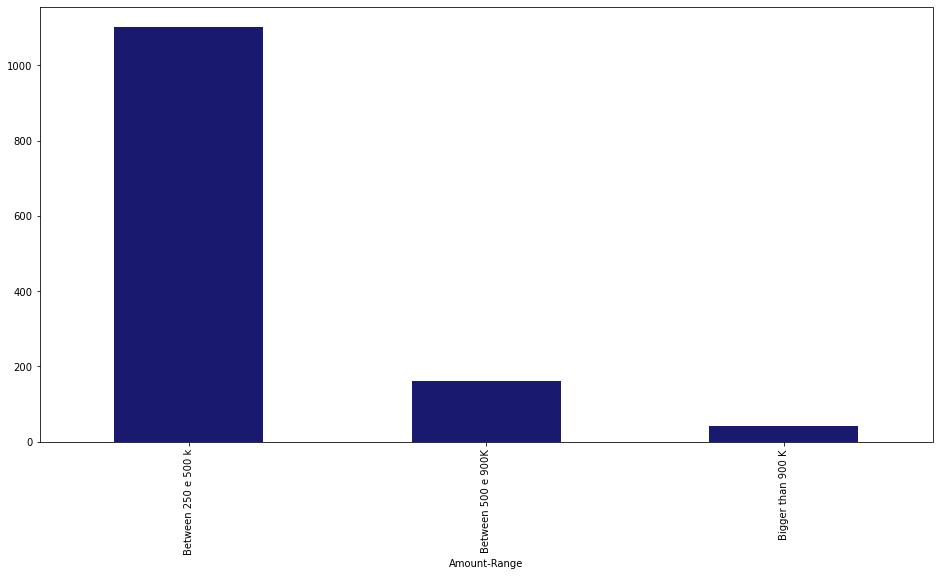

In [28]:
plt.figure(figsize=(16,8))
df1['Amount-Range'] = df1['Amount'].apply(lambda x: 'Less than 250K ' if x < 200000 else ('Between 250 e 500 k' if (x >= 200000 and x <= 500000) else ('Between 500 e 900K' if (x >= 500000 and x <= 900000) else 'Bigger than 900 K')))
df1.groupby('Amount-Range')['Amount'].count().plot(kind='bar', color='midnightblue')
plt.show()

### Repeated transactions:

Now when analyzing transactions repeated three times on the same Day, City, Card Type, and Gender we get:


In [39]:
repeat = df.groupby(["City", "Date", "Card_Type", "Gender"]).Amount.agg(count='count', sum='sum').reset_index().sort_values(by=['count','sum'], ascending=False)

repeat.query('count > 3')

,City,Date,Card_Type,Gender,count,sum
3413,Bengaluru,2014-02-08,Silver,F,6,1104994
9173,Greater Mumbai,2013-10-13,Silver,F,5,1505006
1565,Ahmedabad,2014-10-07,Silver,F,5,1486985
3803,Bengaluru,2014-05-10,Signature,F,5,1126178
1359,Ahmedabad,2014-08-18,Silver,F,5,1024854
...,...,...,...,...,...,...
168,Ahmedabad,2013-10-31,Silver,F,4,240297
1743,Ahmedabad,2014-11-19,Gold,F,4,224606
7309,Delhi,2014-05-10,Silver,M,4,187554
6797,Delhi,2014-01-01,Signature,M,4,158216


We can see that there is no difference between the types of cards used for these transactions.

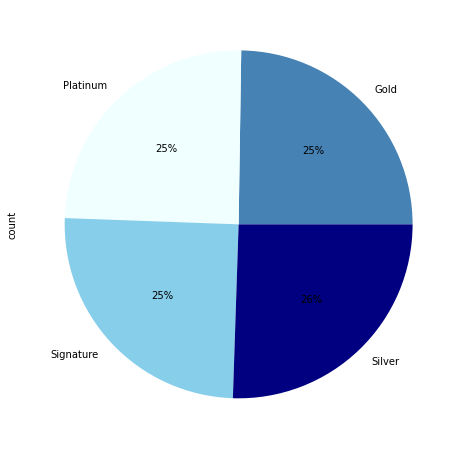

In [46]:

plt.figure(figsize=(16,8))

repeat.groupby(['Card_Type'])['count'].count().plot(
    kind='pie', autopct='%1.0f%%', colors=['steelblue','azure','skyblue','navy'])
plt.show()